In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from collections import Counter
import re
df = pd.read_csv('NYPD_Arrest_Data__Year_to_Date_.csv')
df1 = pd.read_csv('kycd_pd_desc_mapping.csv')

In [26]:
def eda(df):
    print("dataframe shape: ", df.shape)
    print("dataframe columns: ", df.columns)
    print("dataframe dtypes: ", df.dtypes)
eda(df)

dataframe shape:  (71242, 19)
dataframe columns:  Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column'],
      dtype='object')
dataframe dtypes:  ARREST_KEY                    int64
ARREST_DATE                  object
PD_CD                         int64
PD_DESC                      object
KY_CD                       float64
OFNS_DESC                    object
LAW_CODE                     object
LAW_CAT_CD                   object
ARREST_BORO                  object
ARREST_PRECINCT               int64
JURISDICTION_CODE             int64
AGE_GROUP                    object
PERP_SEX                     object
PERP_RACE                    object
X_COORD_CD                    int64
Y_COORD_CD                    int64
Latitude                    float

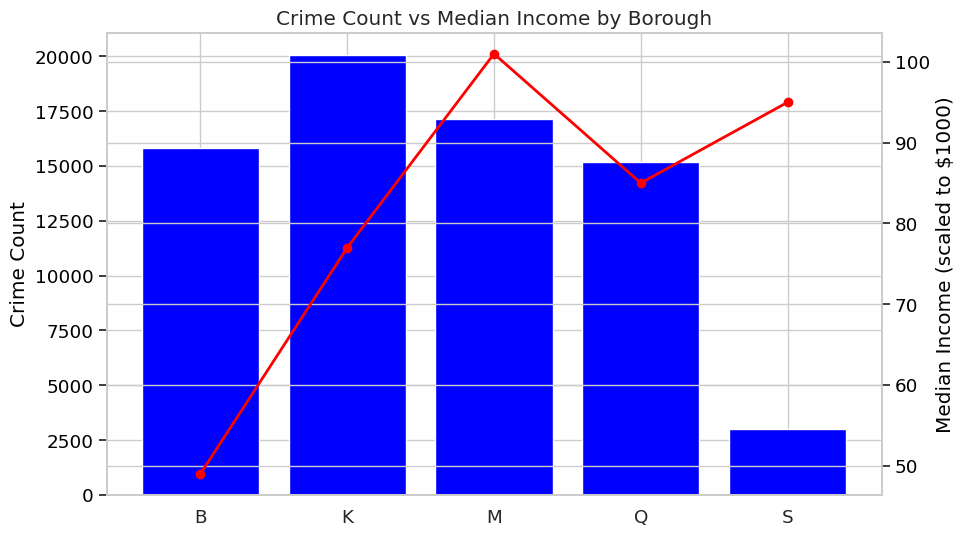

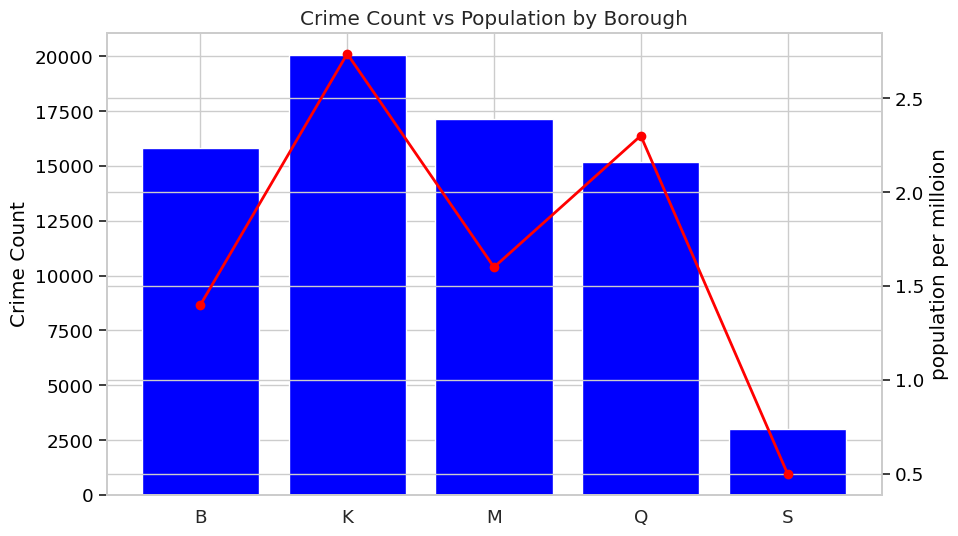

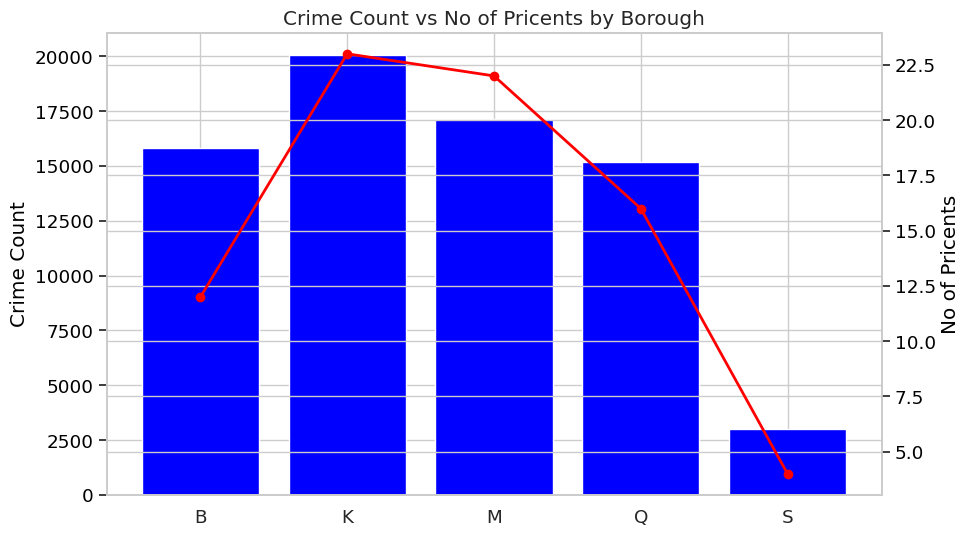

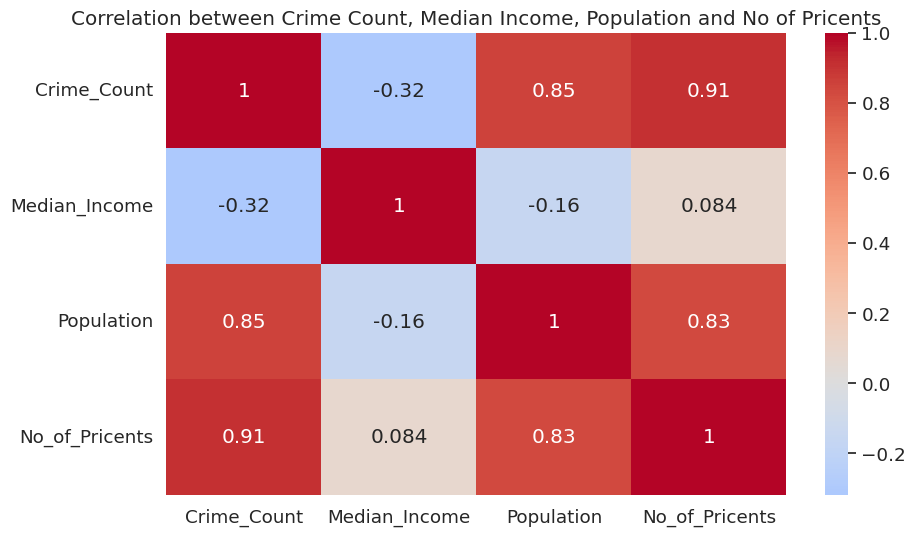

In [27]:
def boro_vise_analyis(df):
    boro_crime_count = df.groupby('ARREST_BORO')['ARREST_KEY'].count()
    boro_avg_income = {
        'B': 49,  # Bronx
        'K': 77,  # Brooklyn
        'M': 101, # Manhattan
        'Q': 85,  # Queens
        'S': 95   # Staten Island
    }
    boro_population = {
        'B': 1.4,  # Bronx
        'K': 2.736, # Brooklyn
        'M': 1.6,   # Manhattan
        'Q': 2.3,   # Queens
        'S': 0.5    # Staten Island
    }
    boro_no_of_pricents = { 
        'B': 12,  # Bronx
        'K': 23,  # Brooklyn
        'M': 22,   # Manhattan
        'Q': 16,  # Queens
        'S': 4  # Staten Island
    }
    boro_df = pd.DataFrame({
        'Borough': boro_crime_count.index,
        'Crime_Count': boro_crime_count.values,
        'Population': [boro_population[boro] for boro in boro_crime_count.index],
        'Median_Income': [boro_avg_income[boro] for boro in boro_crime_count.index],
        'No_of_Pricents': [boro_no_of_pricents[boro] for boro in boro_crime_count.index]
    })
    incomes = [boro_avg_income[boro] for boro in boro_crime_count.index]
    #income vs crime count
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(boro_crime_count.index, boro_crime_count.values, color='blue', label='Crime Count')
    ax1.set_ylabel('Crime Count', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2 = ax1.twinx()
    ax2.plot(boro_crime_count.index, boro_df['Median_Income'], color='red', linewidth=2,marker='o')
    ax2.set_ylabel('Median Income (scaled to $1000)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    plt.title('Crime Count vs Median Income by Borough')
    plt.show()
    #population vs crime count
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(boro_crime_count.index, boro_crime_count.values, color='blue', label='Crime Count')
    ax1.set_ylabel('Crime Count', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2 = ax1.twinx()
    ax2.plot(boro_crime_count.index,boro_df['Population'] , color='red', linewidth=2,marker='o')
    ax2.set_ylabel('population per milloion', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    plt.title('Crime Count vs Population by Borough')
    plt.show()
    #no of pricents vs crime count
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(boro_crime_count.index, boro_crime_count.values, color='blue', label='Crime Count')
    ax1.set_ylabel('Crime Count', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2 = ax1.twinx()
    ax2.plot(boro_crime_count.index,boro_df['No_of_Pricents'] , color='red', linewidth=2,marker='o')
    ax2.set_ylabel('No of Pricents', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    plt.title('Crime Count vs No of Pricents by Borough')
    plt.show()
    #correlation matrix
    fig, ax1 = plt.subplots(figsize=(10, 6))
    corrq=boro_df[['Crime_Count','Median_Income','Population','No_of_Pricents']].corr()
    sns.heatmap(corrq, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Crime Count, Median Income, Population and No of Pricents')
    plt.show()
boro_vise_analyis(df)

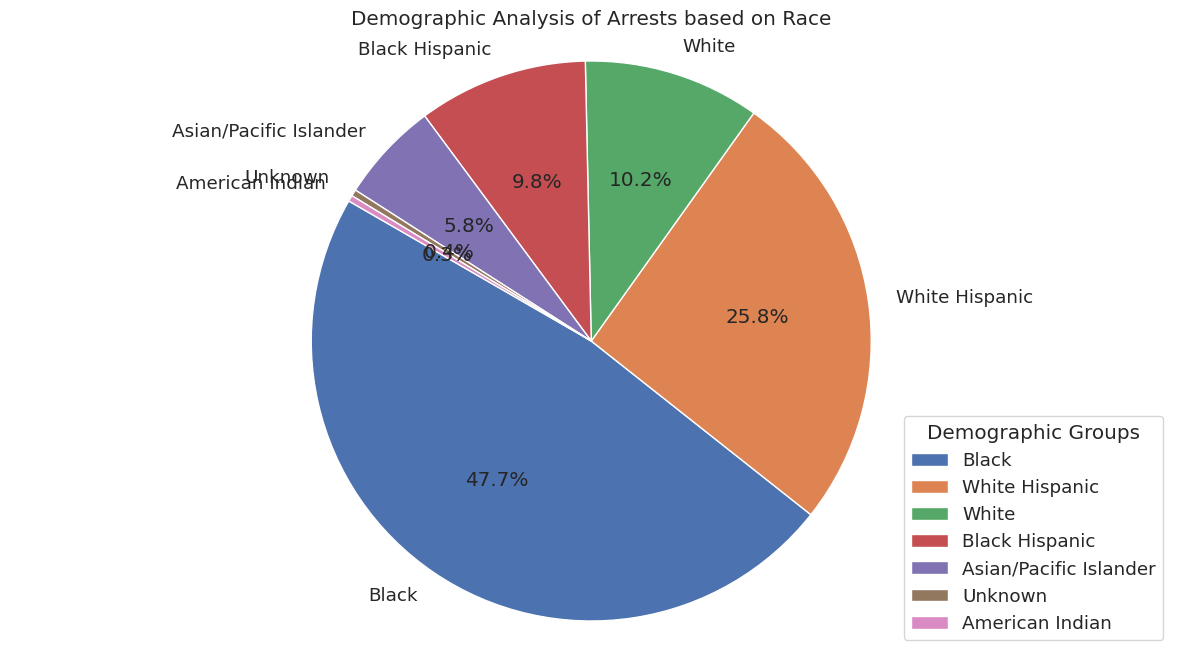

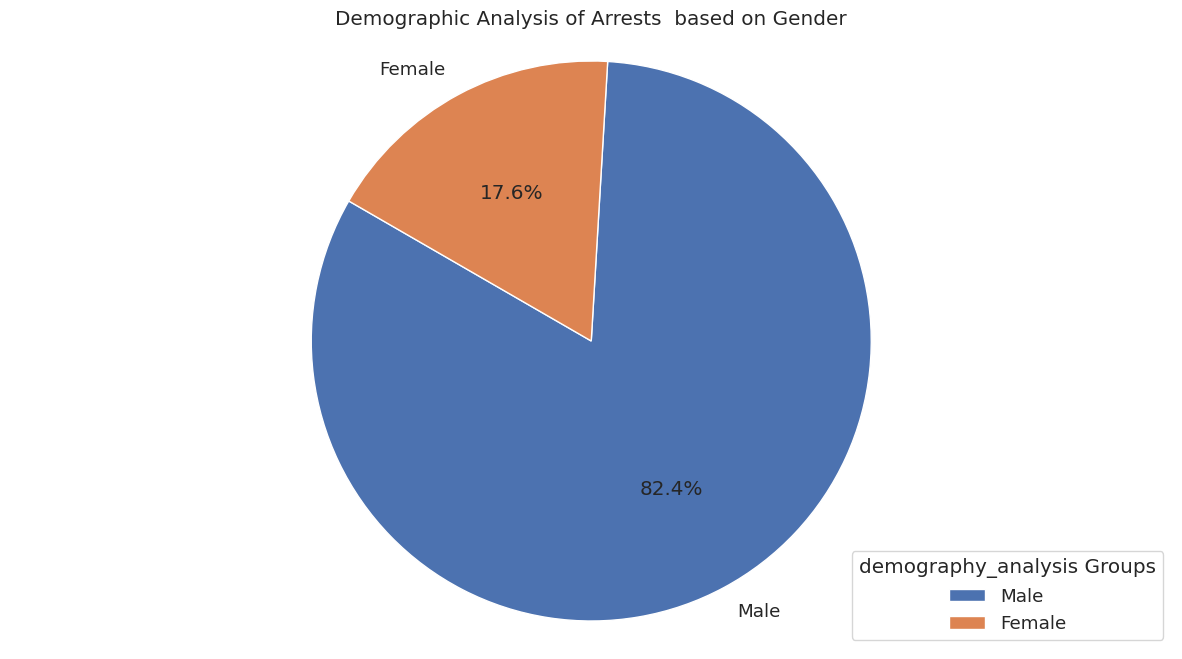

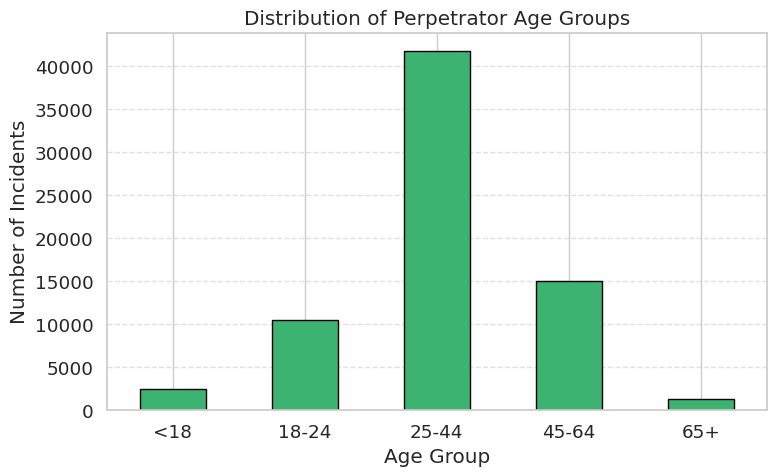

In [28]:
def demography_analysis(df):
    # Demographic analysis baced on race
    demographic_counts = df['PERP_RACE'].value_counts()
    demographic_counts = demographic_counts.rename(index={
    'BLACK': 'Black',
    'WHITE': 'White',
    'WHITE HISPANIC': 'White Hispanic',
    'BLACK HISPANIC': 'Black Hispanic',
    'ASIAN / PACIFIC ISLANDER': 'Asian/Pacific Islander',
    'UNKNOWN': 'Unknown',
    'AMERICAN INDIAN/ALASKAN NATIVE': 'American Indian'
    })

    plt.figure(figsize=(15, 8))
    plt.pie( demographic_counts.values,labels=demographic_counts.index, autopct='%1.1f%%', startangle=150)
    plt.legend(title='Demographic Groups',loc='lower right')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Demographic Analysis of Arrests based on Race')
    plt.show()
    # Demographic analysis based on gender
    demographic_counts = df['PERP_SEX'].value_counts()
    demographic_counts = demographic_counts.rename(index={
        'M': 'Male',
        'F': 'Female',
        'U': 'Unknown'})
    plt.figure(figsize=(15, 8))
    plt.pie(demographic_counts.values,labels=demographic_counts.index, autopct='%1.1f%%', startangle=150)
    plt.legend(title='demography_analysis Groups',loc='lower right')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Demographic Analysis of Arrests  based on Gender')
    # Demographic analysis based on age
    # Desired order of age groups
    age_order = ['<18', '18-24', '25-44', '45-64', '65+']
    age_counts = df['AGE_GROUP'].value_counts().reindex(age_order)
    plt.figure(figsize=(8, 5))
    age_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')

    plt.title("Distribution of Perpetrator Age Groups")
    plt.xlabel("Age Group")
    plt.ylabel("Number of Incidents")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
demography_analysis(df)

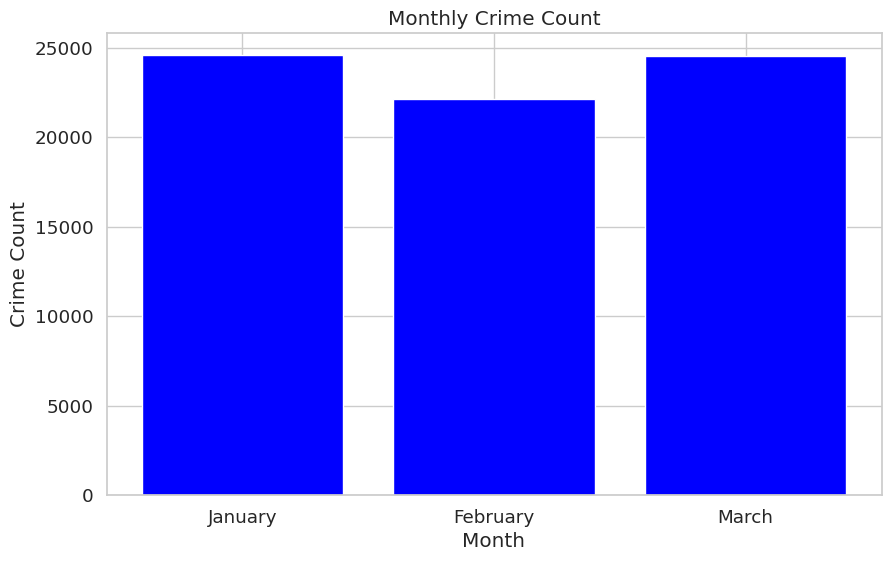

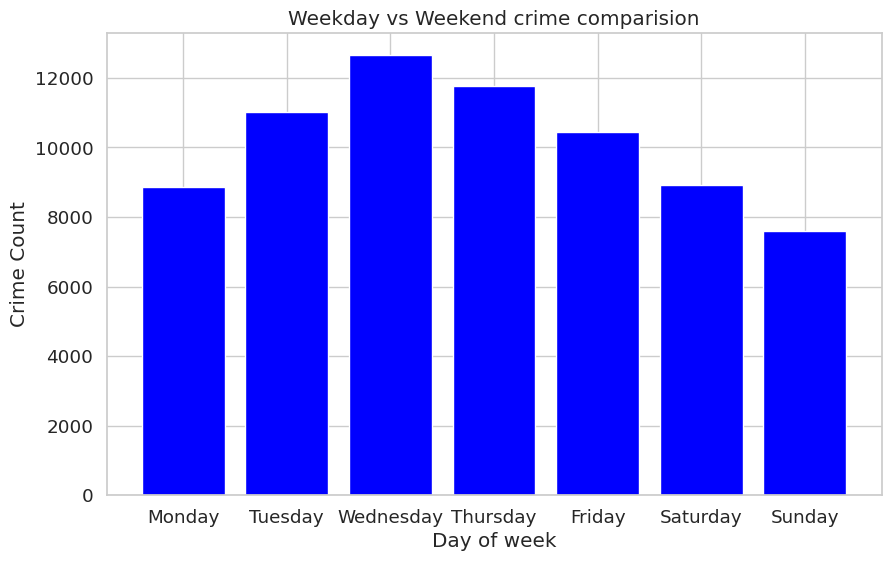

In [29]:
def temporal_analysis(df):
    # Temporal analysis
    df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'])
    df['Month'] = df['ARREST_DATE'].dt.month
    df['Day'] = df['ARREST_DATE'].dt.day
    
    # Monthly crime count
    monthly_crime_count = df.groupby('Month')['ARREST_KEY'].count()
    monthly_crime_count = monthly_crime_count.rename(index={
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    })
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_crime_count.index, monthly_crime_count.values, color='blue')
    plt.title('Monthly Crime Count')
    plt.xlabel('Month')
    plt.ylabel('Crime Count')
    plt.show()
    df['Weekday_Name'] = df['ARREST_DATE'].dt.day_name()
    week_crime_count=df.groupby("Weekday_Name")['ARREST_KEY'].count()
    week_crime_count=week_crime_count.rename(index={
        1: 'Monday',
        2: 'Tuesday',
        3: 'Wednesday',
        4: 'Thursday',
        5: 'Friday',
        6: 'Saturday',
        7: 'Sunday'
    })
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    week_crime_count = week_crime_count.reindex(weekday_order)
    plt.figure(figsize=(10,6))
    plt.bar(week_crime_count.index,week_crime_count.values,color='blue')
    plt.title("Weekday vs Weekend crime comparision")
    plt.xlabel('Day of week')
    plt.ylabel('Crime Count')
    plt.show()
    

temporal_analysis(df)

In [30]:
def crime_hotspot_heatmap(df):
    df_clean = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)]
    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11, tiles='CartoDB dark_matter')
    heat_data = list(zip(df_clean['Latitude'], df_clean['Longitude']))
    HeatMap(heat_data, radius=8, blur=10, max_zoom=13).add_to(nyc_map)
    return nyc_map
crime_hotspot_map = crime_hotspot_heatmap(df)
crime_hotspot_map.save('crime_hotspot_heatmap.html')

In [ ]:

def preprocess_crime_descriptions(df1):
    processed = []
    for desc in df1["PD_DESC"]:
        text = str(desc).lower()

        text = re.sub(r'\b(unclassified|unclass|unk|unknown)\b', '', text)
        text = re.sub(r'\b(attempt|att)\b', 'attempt', text)
        text = re.sub(r'\b(negligent|neglig)\b', 'negligent', text)

        crime_standardization = {
            r'\b(larceny|larc)\b': 'theft',
            r'\b(burglary|burg)\b': 'burglary',
            r'\b(robbery|robb)\b': 'robbery',
            r'\b(assault|asslt)\b': 'assault',
            r'\b(battery|batt)\b': 'battery',
            r'\b(vehicle|auto|motor)\b': 'vehicle',
            r'\b(firearm|gun|weapon)\b': 'weapon',
            r'\b(narcotic|drug|controlled)\b': 'drug',
            r'\b(domestic|family)\b': 'domestic',
            r'\b(sexual|sex)\b': 'sexual',
            r'\b(juvenile|minor|child)\b': 'juvenile'
        }

        for pattern, replacement in crime_standardization.items():
            text = re.sub(pattern, replacement, text)

        text = re.sub(r'\b\d+\b', '', text)
        text = re.sub(r'[^\w\s-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()

        processed.append(text)
    return processed

In [40]:
def get_sentence_embeddings(df1):
    model = SentenceTransformer('all-MiniLM-L6-v2') 
    processed_desc = preprocess_crime_descriptions(df1)
    embeddings = model.encode(processed_desc, show_progress_bar=True)
    return embeddings
print(get_sentence_embeddings(df1).shape)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

(212, 384)


In [33]:
def extract_text_features(df1):
    additional_features = []
    for desc in df1["PD_DESC"]:
        desc_str = str(desc).lower()
        
        # Length-based features
        char_count = len(desc_str)
        word_count = len(desc_str.split())
        comma_count = desc_str.count(',')
        
        # Crime category indicators (binary features)
        violence_keywords = ['murder', 'homicide', 'manslaughter', 'assault', 'battery', 'rape', 'sexual', 'weapon', 'gun', 'knife']
        property_keywords = ['theft', 'larceny', 'burglary', 'robbery', 'steal', 'fraud', 'embezzle']
        drug_keywords = ['drug', 'narcotic', 'controlled', 'substance', 'marijuana', 'cocaine', 'heroin']
        vehicle_keywords = ['vehicle', 'auto', 'car', 'motor', 'traffic', 'dui', 'dwi']
        domestic_keywords = ['domestic', 'family', 'spouse', 'child', 'juvenile']
        
        violence_score = sum(1 for kw in violence_keywords if kw in desc_str)
        property_score = sum(1 for kw in property_keywords if kw in desc_str)
        drug_score = sum(1 for kw in drug_keywords if kw in desc_str)
        vehicle_score = sum(1 for kw in vehicle_keywords if kw in desc_str)
        domestic_score = sum(1 for kw in domestic_keywords if kw in desc_str)
        
        # Severity indicators
        attempt_indicator = 1 if 'attempt' in desc_str else 0
        negligent_indicator = 1 if 'negligent' in desc_str else 0
        unclassified_indicator = 1 if any(term in desc_str for term in ['unclass', 'unknown', 'other']) else 0
        
        additional_features.append([
            char_count, word_count, comma_count,
            violence_score, property_score, drug_score, vehicle_score, domestic_score,
            attempt_indicator, negligent_indicator, unclassified_indicator
        ])
    
    return np.array(additional_features)

In [55]:
def combine_sentence_embeddings_with_features(df1):
    sentence_embeddings = get_sentence_embeddings(df1)
    
    handcrafted_features = extract_text_features(df1)
    scaler = StandardScaler()
    scaled_handcrafted = scaler.fit_transform(handcrafted_features)

    combined_features = np.hstack([sentence_embeddings, scaled_handcrafted])
    
    return combined_features, scaler
features_2d,scaler=combine_sentence_embeddings_with_features(df1)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [58]:
def perform_dbscan(features, eps=1.5, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', n_jobs=-1)
    labels = db.fit_predict(features)
    return labels, db
l,db=perform_dbscan(features_2d)
print(l)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1  1 -1 -1  1 -1  1 -1 -1  0  0  0 -1 -1  0 -1  2  2  2  2 -1 -1  0  2
  0  2  0  2  2  2 -1 -1  0 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  0  0 -1
  1  3  0  0  0 -1  1  1  0 -1  1  1 -1  0 -1 -1  0  1  1  0 -1  1  0  1
  0  3  0 -1  1 -1 -1 -1  0  1  1  1  2 -1 -1 -1 -1  0 -1  0 -1  0  1  1
  1  1  0  1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  1 -1  0 -1 -1 -1 -1 -1
 -1  0  1  3  0 -1  1  1 -1  1  0  0  0  1 -1  0  1  1  1  0  1  3  0  1
  1  0  1 -1  1 -1  0 -1  3  1 -1  0  3  3  0  0 -1 -1  3 -1  0 -1 -1  1
  3  1  1 -1  3  1 -1  1  0  0  0  0 -1  0 -1 -1 -1 -1 -1  0]


In [66]:
def plot_dbscan_clusters(df, features, labels):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(features)
    
    df["Component1"] = reduced[:, 0]
    df["Component2"] = reduced[:, 1]
    df["DBSCAN_Cluster"] = labels

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x="Component1", y="Component2", hue="DBSCAN_Cluster",
        data=df, palette='tab10', s=100, alpha=0.7, edgecolor='k'
    )
    plt.title("DBSCAN Clusters on Sentence Embeddings + Features")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [74]:
def analyze_dbscan_clusters(df, label_col='DBSCAN_Cluster', desc_col='PD_DESC'):
    print("DBSCAN Cluster Analysis:")
    print("=" * 60)

    for cluster_id in sorted(df[label_col].unique()):
        cluster_data = df[df[label_col] == cluster_id]
        cluster_desc = cluster_data[desc_col].tolist()
        
        print(f"\nCluster {cluster_id} ({len(cluster_data)} crimes):")
        for i, desc in enumerate(cluster_desc[:3]):
            print(f"  {i+1}. {desc}")
        
        # Common terms
        words = re.findall(r'\b\w+\b', ' '.join(cluster_desc).lower())
        top_words = Counter(words).most_common(5)
        print("  Common words:", ', '.join(f"{w}({c})" for w, c in top_words))
analyze_dbscan_clusters(df1, label_col='DBSCAN_Cluster', desc_col='PD_DESC')

DBSCAN Cluster Analysis:

Cluster -1 (100 crimes):
  1. MURDER,UNCLASSIFIED
  2. MANSLAUGHTER,UNCLASSIFIED - NO
  3. HOMICIDE, NEGLIGENT, VEHICLE,
  Common words: unclassified(18), 3(12), of(12), 2(11), criminal(10)

Cluster 0 (48 crimes):
  1. STRANGULATION 1ST
  2. OBSCENITY 1
  3. SEX CRIMES
  Common words: 1(9), 2(7), reckless(4), 3(3), sale(3)

Cluster 1 (44 crimes):
  1. STOLEN PROPERTY 2,POSSESSION B
  2. STOLEN PROPERTY 2,1,POSSESSION
  3. FORGERY,M.V. REGISTRATION
  Common words: 2(9), 1(9), criminal(9), 3(8), possession(6)

Cluster 2 (10 crimes):
  1. CONTROLLED SUBSTANCE, SALE 5
  2. CONTROLLED SUBSTANCE, INTENT T
  3. CONTROLLED SUBSTANCE,SALE 3
  Common words: controlled(10), substance(10), sale(5), intent(2), possessi(2)

Cluster 3 (10 crimes):
  1. NY STATE LAWS,UNCLASSIFIED FEL
  2. PUBLIC ADMINISTRATION,UNCLASSI
  3. CRIMINAL MISCHIEF,UNCLASSIFIED 4
  Common words: unclassified(8), public(4), ny(3), state(3), laws(3)


Getting sentence embeddings and handcrafted features...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Running DBSCAN clustering...
Adding cluster results and visualizing...


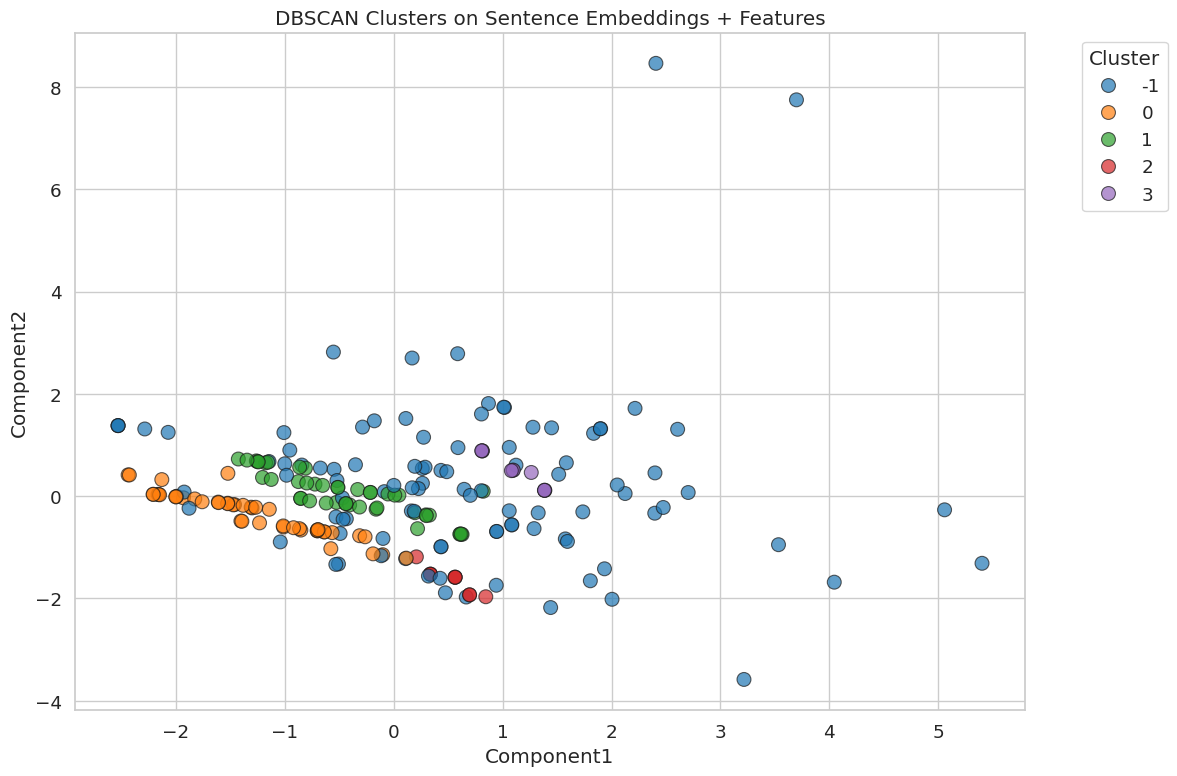

Analyzing clusters...
DBSCAN Cluster Analysis:

Cluster -1 (100 crimes):
  1. MURDER,UNCLASSIFIED
  2. MANSLAUGHTER,UNCLASSIFIED - NO
  3. HOMICIDE, NEGLIGENT, VEHICLE,
  Common words: unclassified(18), 3(12), of(12), 2(11), criminal(10)

Cluster 0 (48 crimes):
  1. STRANGULATION 1ST
  2. OBSCENITY 1
  3. SEX CRIMES
  Common words: 1(9), 2(7), reckless(4), 3(3), sale(3)

Cluster 1 (44 crimes):
  1. STOLEN PROPERTY 2,POSSESSION B
  2. STOLEN PROPERTY 2,1,POSSESSION
  3. FORGERY,M.V. REGISTRATION
  Common words: 2(9), 1(9), criminal(9), 3(8), possession(6)

Cluster 2 (10 crimes):
  1. CONTROLLED SUBSTANCE, SALE 5
  2. CONTROLLED SUBSTANCE, INTENT T
  3. CONTROLLED SUBSTANCE,SALE 3
  Common words: controlled(10), substance(10), sale(5), intent(2), possessi(2)

Cluster 3 (10 crimes):
  1. NY STATE LAWS,UNCLASSIFIED FEL
  2. PUBLIC ADMINISTRATION,UNCLASSI
  3. CRIMINAL MISCHIEF,UNCLASSIFIED 4
  Common words: unclassified(8), public(4), ny(3), state(3), laws(3)

Attaching labeled cluster nam

(     KY_CD                          PD_DESC  Component1  Component2  \
 0    101.0              MURDER,UNCLASSIFIED   -0.554336    2.817642   
 1    101.0   MANSLAUGHTER,UNCLASSIFIED - NO    0.869931    1.811726   
 2    102.0    HOMICIDE, NEGLIGENT, VEHICLE,    3.698629    7.749822   
 3    103.0   HOMICIDE,NEGLIGENT,UNCLASSIFIE    2.407638    8.463226   
 4    104.0                           RAPE 3   -2.531976    1.379952   
 ..     ...                              ...         ...         ...   
 207  995.0           U.S. CODE UNCLASSIFIED    0.000871    0.210377   
 208  995.0         NYC UNCLASSIFIED WARRANT    0.169442    0.164204   
 209  995.0            FUGITIVE/OTHER STATES   -0.351621    0.614925   
 210  995.0  FUGITIVE/OTHER JURISDICTION NYS    0.702767    0.015937   
 211  995.0             NYS PAROLE VIOLATION   -0.920724   -0.616285   
 
      DBSCAN_Cluster  
 0                -1  
 1                -1  
 2                -1  
 3                -1  
 4                -

In [68]:
def run_dbscan_pipeline(df1, df, eps=1.5, min_samples=10):
    print("Getting sentence embeddings and handcrafted features...")
    features, scaler = combine_sentence_embeddings_with_features(df1)
    print("Running DBSCAN clustering...")
    labels, db = perform_dbscan(features, eps=eps, min_samples=min_samples)
    print("Adding cluster results and visualizing...")
    df1["DBSCAN_Cluster"] = labels
    # Make sure df1 has KEY_CD and the cluster column (e.g., DBSCAN_Cluster)
    key_to_cluster_map = df1.set_index("KY_CD")["DBSCAN_Cluster"].to_dict()

    # Map the cluster to df based on KEY_CD
    df["cluster_grp"] = df["KY_CD"].map(key_to_cluster_map)

    plot_dbscan_clusters(df1, features, labels)
    print("Analyzing clusters...")
    analyze_dbscan_clusters(df1)
    print("\nAttaching labeled cluster names (optional)...")
    return df1, df, db
run_dbscan_pipeline(df1,df)

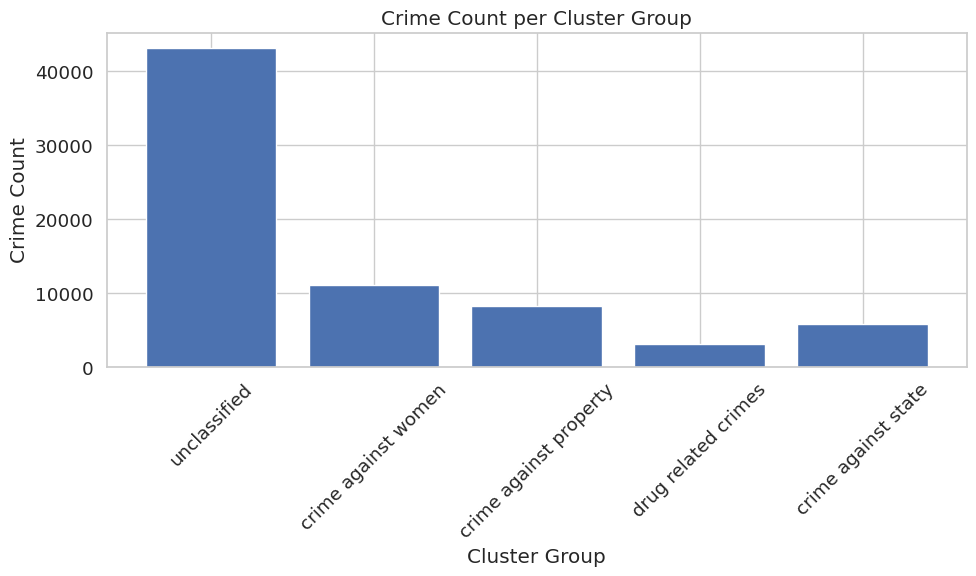

In [78]:
def plot_crime_count_per_cluster(df):
    crime_count_per_cluster = df.groupby('cluster_grp')['ARREST_KEY'].count()
    crime_count_per_cluster=crime_count_per_cluster.rename(index={
        0: 'crime against women',
        1: 'crime against property',
        2: 'drug related crimes',
        3: 'crime against state',
        -1: 'unclassified'
    })
    plt.figure(figsize=(10, 6))
    plt.bar(crime_count_per_cluster.index, crime_count_per_cluster.values)
    plt.xlabel("Cluster Group")
    plt.ylabel("Crime Count")
    plt.title("Crime Count per Cluster Group")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_crime_count_per_cluster(df)
